# Generalized Lasso implementation using ADMM (Alternating Direction Method of Multipliers)

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 1

In [2]:
def show_plot(coef, value, coef_expected = None, value_expected = None, suptitle=None):
    # Plot signal and result
    
    plt.figure(figsize=(16,4))
    plt.subplot(1,2,1)
    plt.plot(coef, label='original')
    if coef_expected is not None:
        plt.plot(coef_expected, label='expected')    
    plt.title('coeficients')
    plt.legend()
    plt.grid()

    plt.subplot(1,2,2)
    plt.plot(value, label='original')
    if value_expected is not None:
        plt.plot(value_expected, label='expected')        
    
    plt.title('value')
    plt.legend()
    plt.grid()
    
    if suptitle is not None:
        plt.suptitle(suptitle)    

    plt.tight_layout()    
    if suptitle is not None:
        plt.subplots_adjust(top=0.85)

## Generate sparce signal and apply random-linear transform

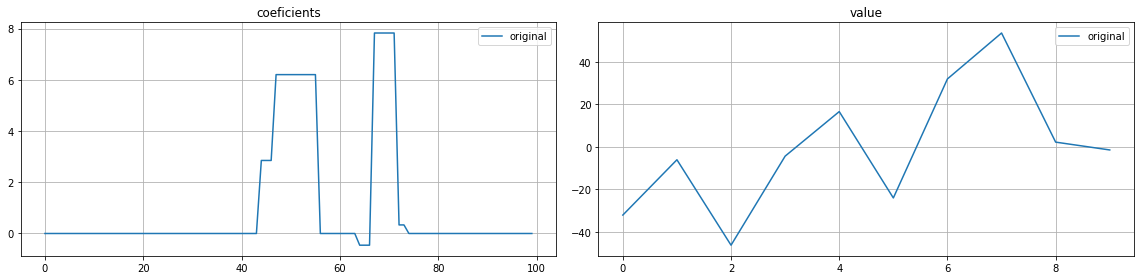

In [3]:
# fix the seed of random
np.random.seed(0)

# Generate signal
idx = np.random.randint(0, 90, 5)
signal = np.zeros(100)
for i in idx:
    signal[i:i+np.random.randint(5, 10)] = np.random.normal(1.0, 5.0, 1)
    #signal[i] = np.random.normal(1.0, 5.0, 1)

# Generate observation matrix(random) and observation result
X = np.random.normal(0.0, 1.0, (10, 100))
y = X.dot(signal)

X_test = np.random.normal(0.0, 1.0, (20, 100))
y_test = X_test.dot(signal)

# Plot signal and result
show_plot(signal, y)

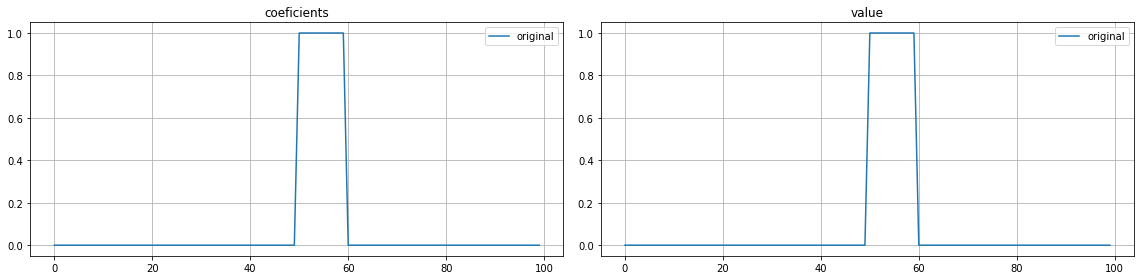

In [4]:
signal = np.zeros(100)
signal[50:60] = 1

#X = np.random.normal(0.0, 1.0, (10, 100))
X = np.eye(100)
y = X.dot(signal)

# Plot signal and result
show_plot(signal, y)

In [5]:
from logging import getLogger

import numpy as np

from sklearn.utils import check_array, check_X_y
from sklearn.base import RegressorMixin
from sklearn.linear_model.base import LinearModel

logger = getLogger(__name__)


def _soft_threshold(X: np.ndarray, thresh: float) -> np.ndarray:
    return np.where(np.abs(X) <= thresh, 0, X - thresh * np.sign(X))


class LassoADMM(LinearModel, RegressorMixin):
    """Linear Model trained with L1 prior as regularizer (aka the Lasso)
    The optimization objective for Lasso is::
        (1 / (2 * n_samples)) * ||y - Xw||^2_2 + alpha * ||w||_1
    Technically the Lasso model is optimizing the same objective function as
    the Elastic Net with ``l1_ratio=1.0`` (no L2 penalty).
    """

    def __init__(self, alpha=1.0, rho=1.0, fit_intercept=True,
                 normalize=False, copy_X=True, max_iter=1000,
                 tol=0.0001):
        self.alpha = alpha
        self.rho = rho
        self.fit_intercept = fit_intercept
        self.normalize = normalize
        self.copy_X = copy_X
        self.max_iter = max_iter
        self.tol = tol

        self.threshold = alpha / rho
        self.coef_ = None

    def fit(self, X, y, check_input=False):
        if self.alpha == 0:
            logger.warning("""
With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator            
""")

        if check_input:
            X, y = check_X_y(X, y, accept_sparse='csc',
                             order='F', dtype=[np.float64, np.float32],
                             copy=self.copy_X and self.fit_intercept,
                             multi_output=True, y_numeric=True)
            y = check_array(y, order='F', copy=False, dtype=X.dtype.type,
                            ensure_2d=False)

        X, y, X_offset, y_offset, X_scale = self._preprocess_data(X, y, fit_intercept=self.fit_intercept,
                                                                  normalize=self.normalize,
                                                                  copy=self.copy_X and not check_input)

        if y.ndim == 1:
            y = y[:, np.newaxis]

        self.coef_ = self._admm(X, y)
        self._set_intercept(X_offset, y_offset, X_scale)

        # workaround since _set_intercept will cast self.coef_ into X.dtype
        self.coef_ = np.asarray(self.coef_, dtype=X.dtype)

        return self

    def _cost_function(self, y, X, w):
        n_samples = X.shape[0]
        return np.linalg.norm(y - X.dot(w)) / n_samples + self.alpha * np.sum(np.abs(w))

    def _admm(self, X, y):
        n_samples, n_features = X.shape
        n_targets = y.shape[1]

        # Initialize ADMM parameters
        w_t = X.T.dot(y) / n_samples
        z_t = w_t.copy()
        h_t = np.zeros(w_t.shape)

        # Calculate inverse matrix
        inv_matrix = np.linalg.inv(X.T.dot(X) / n_samples + self.rho * np.eye(n_features))

        self.n_iter_ = []
        # Update ADMM parameters by columns
        for k in range(n_targets):
            for t in range(self.max_iter):
                # current cost
                gap = self._cost_function(y[:, k], X, w_t[:, k])

                # Update
                w_t[:, k] = inv_matrix.dot(X.T.dot(y[:, k]) / n_samples + (self.rho * z_t[:, k]) - h_t[:, k])
                z_t[:, k] = _soft_threshold(w_t[:, k] + (h_t[:, k] / self.rho), self.threshold)
                h_t[:, k] += self.rho * (w_t[:, k] - z_t[:, k])

                # after cost
                gap = np.abs(gap - self._cost_function(y[:, k], X, w_t[:, k]))
                if gap < self.tol:
                    break
            self.n_iter_.append(t)

        if n_targets == 1:
            self.n_iter_ = self.n_iter_[0]

        return np.squeeze(z_t)

In [6]:
def lasso_admm(y, X):
    n_samples, n_features = X.shape
    beta = X.T.dot(y) / n_samples
    gamma = beta.copy()

    threshold = 1
    p = 1
    u = np.zeros(beta.shape)
    
    inv_matrix = np.linalg.inv(X.T.dot(X) + n_samples*p*np.eye(n_features))
    
    for i in range(1000):
        beta = inv_matrix.dot(X.T.dot(y) + n_samples*p*(gamma - u/p))
        gamma = _soft_threshold(beta+u/p, threshold)
        u += p*(beta - gamma)
        
    return gamma
    
    
def glasso_admm(y, X, D):
    n_samples, n_features = X.shape
    beta = X.T.dot(y) / n_samples
    gamma = beta.copy()

    threshold = 0.1
    p = 1
    u = np.zeros(beta.shape)
    
    inv_matrix = np.linalg.inv(X.T.dot(X) + n_samples*p*D.T.dot(D))
    
    for i in range(100):
        beta = inv_matrix.dot(X.T.dot(y) + n_samples*p*D.T.dot(gamma - u/p))
        gamma = _soft_threshold(D.dot(beta)+u/p, threshold)
        u += p*(D.dot(beta) - gamma)
        
    return beta

# Fused Lasso
l1 = 0.01
l2 = 0.01

#D = l1*(np.eye(X.shape[1])) + l2*(- np.eye(X.shape[1]) + np.eye(X.shape[1]+1)[1:, :-1])

D_fused = np.eye(X.shape[1]) - np.eye(X.shape[1]+1)[:-1, 1:]
D_fused[0,0] = 0
D = l1*(np.eye(X.shape[1]))+(l2*D_fused)

glasso_signal = glasso_admm(y, X, D)
glasso_predict = X.dot(glasso_signal)

In [7]:
D

array([[ 0.01,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [-0.01,  0.02,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [ 0.  , -0.01,  0.02, ...,  0.  ,  0.  ,  0.  ],
       ...,
       [ 0.  ,  0.  ,  0.  , ...,  0.02,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  , ..., -0.01,  0.02,  0.  ],
       [ 0.  ,  0.  ,  0.  , ...,  0.  , -0.01,  0.02]])

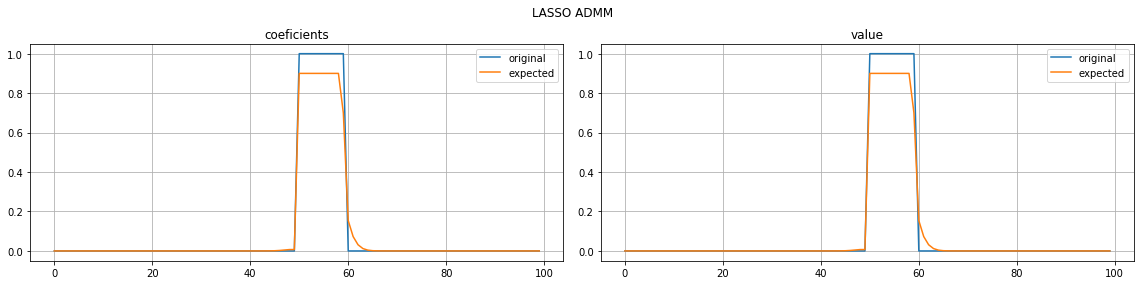

In [8]:
# Plot signal and result (ADMM)
show_plot(signal, y, glasso_signal, glasso_predict, 'LASSO ADMM')